# Install and import libraries

In [ ]:
!pip install twomodalbert

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from twomodalbert.DataPreparation import TwoModalDataPreparation
from twomodalbert.Trainer import TwoModalBertTrainer
import os
import pandas as pd
import torch

from twomodalbert.Model import TwoModalBERTModel
from configparser import ConfigParser
from twomodalbert.Inference import predict_on_text, test_model

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read `config.ini` file

In [ ]:
config = ConfigParser()
config.read("config.ini")


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize modules

In [ ]:
DataPreparation = TwoModalDataPreparation(config=config)
Trainer = TwoModalBertTrainer(device=DEVICE, config=config)

# Load and preprocess input data

In [ ]:
# load data
src_df_path = "/content/drive/MyDrive/TheOffice/The-Office-Lines-V4.csv"
src_df = pd.read_csv(src_df_path)
src_df["context"] = src_df["line"].shift(1)
df = src_df[["line", "context", "speaker"]]
SELECTED_SPEAKERS = [
    "Michael",
    "Jim",
    "Pam",
    "Dwight",
    "Jan",
    "Phyllis",
    "Stanley",
    "Oscar",
    "Angela",
    "Kevin",
    "Ryan",
    "Creed",
]
df = df[df["speaker"].isin(SELECTED_SPEAKERS)]
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["speaker"])
df.head()

,line,context,speaker,label
0,All right Jim. Your quarterlies look very good...,NaN,Michael,6
1,"Oh, I told you. I couldn't close it. So...",All right Jim. Your quarterlies look very good...,Jim,4
2,So you've come to the master for guidance? Is ...,"Oh, I told you. I couldn't close it. So...",Michael,6
3,"Actually, you called me in here, but yeah.",So you've come to the master for guidance? Is ...,Jim,4
4,"All right. Well, let me show you how it's done.","Actually, you called me in here, but yeah.",Michael,6


# Create data loaders

In [ ]:
(
    train_data_loader,
    train,
    val_data_loader,
    val,
    test_data_loader,
    test,
) = DataPreparation.prepare_data(
    df,
    text_column="line",
    context_column="context",
    label_column="label",
    train_size=0.8,
    val_size=0.1,
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Train model
Train model with `text_size = 100` and `context_size = 50`.

In [ ]:
model, history = Trainer.train_model(
    train_data_loader,
    train,
    val_data_loader,
    val,
    text_size=100,
    context_size=50,
    binary=False,
    text_p=0.3,
    context_p=0.3,
    output_p=0.3,
)


LINE SIZE = 100, CONTEXT SIZE = 50


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train loss 2.342239562644712 accuracy 0.2694288310726667
Val loss 2.2843470911099675 accuracy 0.3297442799461642

Epoch 2/3
----------
Train loss 2.3012508903065867 accuracy 0.3074955403722527
Val loss 2.2596986119839255 accuracy 0.3580080753701211

Epoch 3/3
----------
Train loss 2.269613212966508 accuracy 0.3401097236713675
Val loss 2.2487472996691267 accuracy 0.36823687752355316



In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.2694, device='cuda:0', dtype=torch.float64),
              tensor(0.3075, device='cuda:0', dtype=torch.float64),
              tensor(0.3401, device='cuda:0', dtype=torch.float64)],
             'train_loss': [2.342239562644712,
              2.3012508903065867,
              2.269613212966508],
             'val_acc': [tensor(0.3297, device='cuda:0', dtype=torch.float64),
              tensor(0.3580, device='cuda:0', dtype=torch.float64),
              tensor(0.3682, device='cuda:0', dtype=torch.float64)],
             'val_loss': [2.2843470911099675,
              2.2596986119839255,
              2.2487472996691267]})

# Load the model

In [ ]:
model = TwoModalBERTModel(
    text_size=100,
    context_size=50,
    binary=False,
    text_p=0.3,
    context_p=0.3,
    output_p=0.3,
)
model.load_state_dict(torch.load(config["GENERAL"]["MODEL_SAVE_PATH"]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
model = model.to(DEVICE)

# Evaluate the model on a test set

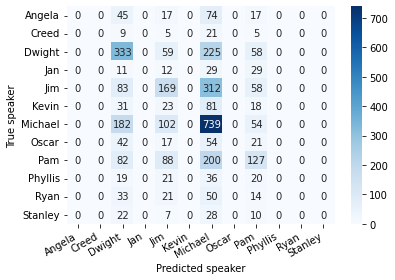

In [ ]:
y_pred, y_test = test_model(model, test_data_loader, DEVICE)
y_pred, y_test = [e.cpu() for e in y_pred], [e.cpu() for e in y_test]

# print confusion matrix - helper function
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("True speaker")
    plt.xlabel("Predicted speaker")


cm = confusion_matrix(y_test, y_pred)
speakers_labels = (
    df[["speaker", "label"]].groupby(["speaker"]).agg("max").to_dict()["label"]
)
df_cm = pd.DataFrame(cm, index=speakers_labels, columns=speakers_labels)
show_confusion_matrix(df_cm)

# Can we do better?
Let's decrease the `context_size = 1`

LINE SIZE = 100, CONTEXT SIZE = 1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train loss 2.360910974013658 accuracy 0.2526337046884992
Val loss 2.3283105096080274 accuracy 0.29017496635262446

Epoch 2/3
----------
Train loss 2.359498110071715 accuracy 0.2520615260341288
Val loss 2.3283366097912768 accuracy 0.29017496635262446

Epoch 3/3
----------
Train loss 2.3577148111905215 accuracy 0.25404732254047324
Val loss 2.3283410926745174 accuracy 0.29017496635262446



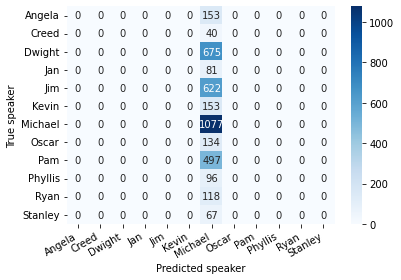

In [ ]:
model, _ = Trainer.train_model(
    train_data_loader,
    train,
    val_data_loader,
    val,
    text_size=100,
    context_size=1,
    binary=False,
    text_p=0.3,
    context_p=0.3,
    output_p=0.3,
)

y_pred, y_test = test_model(model, test_data_loader, DEVICE)
y_pred, y_test = [e.cpu() for e in y_pred], [e.cpu() for e in y_test]

cm = confusion_matrix(y_test, y_pred)
speakers_labels = (
    df[["speaker", "label"]].groupby(["speaker"]).agg("max").to_dict()["label"]
)
df_cm = pd.DataFrame(cm, index=speakers_labels, columns=speakers_labels)
show_confusion_matrix(df_cm)

# For the best model run inference on two input sentences

In [ ]:
# run on new pair of texts
line = "Dwight is my best friend."
context = "What do you think about Dwight?"

predict_on_text(model, line, context, DEVICE)

11

In [ ]:
speakers_mapping = {y: x for x, y in speakers_labels.items()}
speakers_mapping[11]

'Stanley'